# 3W dataset's General Presentation

This is a general presentation of the 3W dataset, to the best of its authors' knowledge, the first realistic and public dataset with rare undesirable real events in oil wells that can be readily used as a benchmark dataset for development of machine learning techniques related to inherent difficulties of actual data.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook presents the 3W dataset in a general way. For this, some tables, graphs, and statistics are presented.

# 2. Imports and Configurations

In [2]:
import sys
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import bisect
import sklearn
import sklearn.model_selection
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [3]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":

                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                        
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True):
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [4]:
if pathlib.Path('dset_sgd.pkl').exists():
  with open('dset_sgd.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_sgd.pkl', 'wb') as f:
      pickle.dump(dset, f)

In [5]:
flist0 = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]

train_df, test_df = dset.split(real=True, simul=True, drawn=True, test_size=0.2, val_size=0, sample_n=None)

Instances Train: 1584  Test: 397


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

# Preprocessing

The following table shows the amount of instances that compose the 3W dataset, by knowledge source (real, simulated and hand-drawn instances) and by instance label.

In [6]:
class CustomDataGen():
    '''
    Generator for Keras models of 3W dataset based on:
    https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
    
    '''
    
    def __init__(self, df, X_col, y_col, categories,
                 batch_size,
                 seq_length=15,
                 tmp_path='/tmp'):
        
        self.df = df.copy().reset_index()
        self.X_col = X_col
        self.y_col = y_col
        self.categories = categories
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.tmp_path = pathlib.Path(tmp_path)
        self.file = None
        self.dt = None
        
        self.n = self.__calc_n()
    
    def __calc_n(self):
        self.df['nbatches'] = np.int32(np.ceil((np.ceil(self.df['nlines'] / 60)-self.seq_length+1)/self.batch_size))
        self.df['ibatch'] = self.df['nbatches'].cumsum() - 1
        return int(self.df['nbatches'].sum())
    
    def plot(self, ifile):
        
        ds = self.__get_ds(self.df['path'][ifile], Norm=False)
        
        fig, axs = plt.subplots(nrows=len(self.X_col)+1, figsize=(10, 12), sharex=True)
        
        fig.suptitle(self.df['path'][ifile])

        for i, vs in enumerate(self.X_col):
            axs[i].plot(ds.index, ds[(vs, 'mean')])
            axs[i].fill_between(ds.index, ds[(vs, 'mean')]-1.96*ds[(vs, 'std')], 
                            ds[(vs, 'mean')]+1.96*ds[(vs, 'std')], 
                            alpha=0.2)
            axs[i].set_ylabel(vs)
            axs[i].grid()
        
        id = np.argsort(ds[(self.y_col, 'mode')])
        
        axs[i+1].scatter([ds.index[i] for i in id], [str(ds[(self.y_col, 'mode')][i]) for i in id], marker='.')
        
        axs[i+1].set_ylabel(self.y_col)
        
        axs[i+1].set_xlabel('minute')

        plt.show()    
    
    def on_epoch_end(self):
            pass
    
    def pkl_path(self, p):
        new_p = self.tmp_path.joinpath(p.parts[-2], p.stem+'.pkl')
        new_p.parent.mkdir(exist_ok=True, parents=True)
        return new_p
    
    def __get_ds(self, p, Norm=True):
    
        pkl_p = self.pkl_path(p)
        
        if pkl_p.exists():
            ds = pd.read_pickle(pkl_p)
        else:
        
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])

            if np.any(dfo[self.y_col].isna()):
                dfo[self.y_col] = dfo[self.y_col].fillna(method='ffill')
            dfo[self.y_col] = dfo[self.y_col].astype('int')

            flist = []
            flist0 = []
            for f in self.X_col:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist.append(f)
                    else:
                        flist0.append(f)
                else:
                    flist.append(f)

            fdict=dict()
            for f in flist:
                fdict[f] = ['mean','std']

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.y_col] = [mode]

            dfo['minute'] = (dfo.index-dfo.index[0])//np.timedelta64(1,'m')

            ds = dfo.groupby('minute').agg(fdict)

            #ds = ds.iloc[:-1]

            for f in flist0:
                ds[f, 'mean'] = np.NaN
                ds[f, 'std'] = np.NaN
                
            ds.to_pickle(pkl_p)
        
        if Norm:
            ds = self.__Norm(ds)
            if ds.isnull().any().any():
                print(p, pkl_p)
        
        return ds[self.X_col + [self.y_col]]
        
    def __Norm(self, ds, nas_v=0):
        dn = ds.fillna(value=nas_v)
        sc = sklearn.preprocessing.StandardScaler()
        dn = pd.DataFrame(sc.fit_transform(dn.values), 
                                           index=dn.index, 
                                           columns=dn.columns)
        dn[(self.y_col, 'mode')] = ds[(self.y_col, 'mode')]
        return dn
        
    def __get_output(self, y):
        
        ohe = sklearn.preprocessing.OneHotEncoder(categories=self.categories, sparse= False)
        
        return ohe.fit_transform(y)
    
    def __get_data(self, i, j, p):
        # Generates data containing batch_size samples

        if p != self.file:
            self.ts = self.__get_ds(p)
            self.file = p

        nf = len(self.X_col)
        mat = np.zeros(shape=(self.batch_size, 2*nf*self.seq_length))
        
        for k in range(self.batch_size):
            if self.seq_length+k+j*self.batch_size > len(self.ts.index):
                mat = mat[:k]
                break
            mat[k] = np.reshape(self.ts[k+j*self.batch_size:self.seq_length+k+j*self.batch_size][self.X_col].to_numpy(), (1, -1))
        return mat, self.ts.iloc[j*self.batch_size+self.seq_length-1:j*self.batch_size+self.seq_length+self.batch_size-1][(self.y_col, 'mode')].to_numpy()
    
    def __getitem__(self, index):
        
        i = bisect.bisect_left(self.df.ibatch, index)
        if i > 0:
            j = index - self.df.ibatch[i-1] - 1
        else:
            j = index
        
        p = self.df.path[i]       
        
        # print(index, i, j, p)
        
        X, y = self.__get_data(i, j, p)        
        
        return X, y #self.__get_output(y)
    
    def __len__(self):
        return self.n
    
    def get_y(self):
        y = np.empty(0, 'int')
        for p in self.df['path']:
            pkl_p = self.pkl_path(p)
            if pkl_p.exists():
                ds = pd.read_pickle(pkl_p)
            else:
                ds = self.__get_ds(p, Norm = False)
            y = np.append(y, ds[self.y_col].iloc[self.seq_length-1:].astype('int'))
        return y

In [6]:
train = CustomDataGen(train_df, flist0, 'class', categories, 64, 30, 'D:/datatmp')

In [ ]:
ys = []
for i in range(train.__len__()):
    X, y = train.__getitem__(i)
    ys += list(y)

In [9]:
yss = train.get_y()
w = dict(zip(np.unique(yss), compute_class_weight('balanced', classes=np.unique(yss), y=yss)))
for j in categories:
    if j not in w.keys():
        w[j] = 1.0

# Model

In [7]:
%%time

transformer = IncrementalPCA()

train = CustomDataGen(train_df, flist0, 'class', categories, 128, 30, 'D:/datatmp')
n = train.__len__()
for i in range(n):
    print('\r' + str(i+1) +  ' / ' + str(n), end='    ', flush=True)
    X, y = train.__getitem__(i)
    if len(y) == 128:
        transformer.partial_fit(X)
print('\n')

5825 / 5825                                                                                                                                                                                                                                                                                   

Wall time: 11min 36s


In [8]:
sum(transformer.explained_variance_ratio_[:24])

0.7514824513613413

In [11]:
nc = 24

yss = train.get_y()
N = len(yss)
Xr = np.empty(shape=(N, nc), dtype='float')
j = 0
n = train.__len__()
for i in range(n):
    print('\r' + str(i+1) +  ' / ' + str(n), end='    ', flush=True)
    X, y = train.__getitem__(i)
    k = len(y)
    Xr[j:j+k] = transformer.transform(X)[:, :nc]
    j += k
Xr.shape

5825 / 5825                   

(627756, 24)

In [26]:
# Number of trees in random forest
n_estimators = [200]
# Maximum number of levels in tree
max_depth = [50, 60]
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [6, 8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [200], 'max_depth': [50, 60], 'min_samples_split': [5], 'min_samples_leaf': [6, 8]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced', random_state=200560)
# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, 
                               verbose=2, random_state=200560, n_jobs = 2)
# Fit the random search model
rf_random.fit(Xr, yss)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=200560),
                   n_jobs=2,
                   param_distributions={'max_depth': [50, 60],
                                        'min_samples_leaf': [6, 8],
                                        'min_samples_split': [5],
                                        'n_estimators': [200]},
                   random_state=200560, verbose=2)

In [29]:
rf_random.cv_results_
rf_random.best_params_, rf_random.best_score_

({'n_estimators': 200,
  'min_samples_split': 5,
  'min_samples_leaf': 6,
  'max_depth': 60},
 0.8940320761569781)

In [24]:
%%time

#yss = train.get_y()
clf = RandomForestClassifier(n_estimators=200, min_samples_split= 5, min_samples_leaf=6,
                             max_depth=60, class_weight='balanced', random_state=200560, n_jobs=-1)
clf.fit(Xr, yss)
ypreds = clf.predict(Xr)
print(classification_report(yss, ypreds, zero_division=True))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    131031
           1       0.99      1.00      0.99     39037
           2       1.00      1.00      1.00      4945
           3       1.00      1.00      1.00     62154
           4       0.96      1.00      0.98     24965
           5       1.00      0.99      1.00    140226
           6       1.00      1.00      1.00     51734
           7       0.99      1.00      1.00      1728
           8       0.99      1.00      1.00      8313
         101       1.00      0.99      1.00     69210
         102       1.00      1.00      1.00      1887
         105       0.97      1.00      0.99     25999
         106       0.99      1.00      1.00     20782
         107       1.00      1.00      1.00     26758
         108       1.00      1.00      1.00     18987

    accuracy                           1.00    627756
   macro avg       0.99      1.00      1.00    627756
weighted avg       1.00   

In [30]:
test = CustomDataGen(test_df, flist0, 'class', categories, 128, 30, 'D:/datatmp')

Xt = np.empty(shape=(0, nc), dtype='float')
for i in range(test.__len__()):
    print('\r' + str(i+1) +  ' / ' + str(test.__len__()), end='    ', flush=True)
    X, y = test.__getitem__(i)
    Xt = np.append(Xt, transformer.transform(X)[:, :nc], axis=0)
Xt.shape

1503 / 1503        

(162695, 24)

In [31]:
yts = test.get_y()
ypreds = clf.predict(Xt)
print(classification_report(yts, ypreds, zero_division=True))

              precision    recall  f1-score   support

           0       0.81      0.92      0.87     33789
           1       0.87      0.84      0.86      9399
           2       0.99      0.95      0.97      1097
           3       0.97      0.91      0.94     15400
           4       0.67      0.77      0.72      6246
           5       1.00      0.97      0.98     35960
           6       0.99      0.99      0.99     12914
           7       1.00      0.83      0.91        87
           8       0.84      0.96      0.90      1746
         101       0.88      0.86      0.87     18727
         102       0.99      0.56      0.71       452
         105       0.91      0.97      0.94      5151
         106       0.97      0.96      0.97      5173
         107       0.95      0.76      0.84     11580
         108       0.98      0.87      0.92      4974

    accuracy                           0.91    162695
   macro avg       0.92      0.87      0.89    162695
weighted avg       0.91   

In [20]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results
    
    https://www.kaggle.com/code/grfiv4/displaying-the-results-of-a-grid-search

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()


best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 60}
best score:      0.89403 (+/-0.00358)
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 60,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 6,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 200560,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,544.649995,5.430461,7.934783,0.055493,200,5,6,60,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.894037,0.898414,0.889645,0.894032,0.003580,1
0,539.802888,6.439135,7.794159,0.059439,200,5,6,50,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.893263,0.898500,0.888943,0.893569,0.003908,2
1,538.406622,6.513911,7.694757,0.033785,200,5,8,50,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.892493,0.898051,0.887160,0.892568,0.004447,3
3,535.384044,6.122973,7.442757,0.332006,200,5,8,60,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.892780,0.898089,0.886673,0.892514,0.004665,4


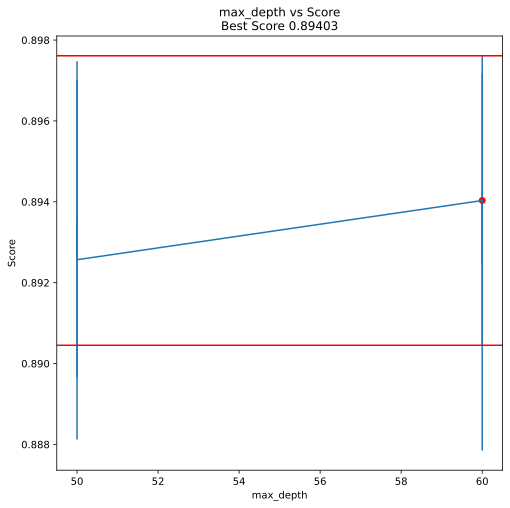

In [28]:
GridSearch_table_plot(rf_random, 'max_depth', negative=False)